## Constants

In [1]:
pathToTrainImages = "D:/Perfect Shape Images/Train/"
pathToTestImages = "D:/Perfect Shape Images/Test/"

In [2]:
BATCH_SIZE = 4

## Imports

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import os

## Create Dataloader

### Create Dataloader Class

In [4]:
class ShapeDataset(Dataset):
    """Shape dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample. -> Not used
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir,
                                str(idx)+ '.jpg')
        image = cv2.imread(img_name)

        if self.transform:
            image = self.transform(image)

        #perfect square should yield strongest activation which will be 1
        return image, 1

### Set Transforms

In [5]:
transform = transforms.ToTensor()

### Create datasets and dataloaders

In [6]:
trainset = ShapeDataset(pathToTrainImages, transform)
testset = ShapeDataset(pathToTrainImages, transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## View Sample Images + Test Loaders

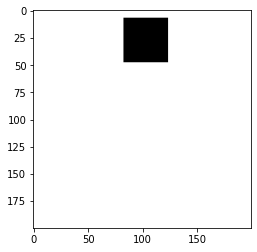

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, label = dataiter.next()

npimg = np.transpose(images[0], (1, 2, 0))

plt.imshow(npimg)

## Create CNN

### Define Network

In [33]:
class SquareNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 10)
        self.conv2 = nn.Conv2d(6, 16, 10)
        self.fc1 = nn.Linear(529984, 120)
        self.fc2 = nn.Linear(120, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [34]:
net = SquareNet()

## Define Loss Function and Optimizer

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

In [36]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        labels = labels[...,None]

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.000
[1,    10] loss: 0.000
[1,    15] loss: 0.000
[1,    20] loss: 0.000
[1,    25] loss: 0.000
[2,     5] loss: 0.000
[2,    10] loss: 0.000
[2,    15] loss: 0.000
[2,    20] loss: 0.000
[2,    25] loss: 0.000
Finished Training


In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

outputs = net(images)

In [38]:
outputs

tensor([[0.4607],
        [0.4617],
        [0.4606],
        [0.4600]], grad_fn=<SigmoidBackward0>)

In [39]:
rec = torch.Tensor(cv2.imread(pathToTestImages + "rectangle.jpg"))
rec = rec[...,None]
rec = np.transpose(rec, (3, 2, 0, 1))
output = net(rec)

In [40]:
output

tensor([[0.9253]], grad_fn=<SigmoidBackward0>)